### Explanation:

- **Data:** We created a synthetic time series with trend, seasonality, and noise to mimic daily logins.
- **Preprocessing:** Normalized the data and split it into sequences (10-day windows to predict the next day).
- **LiquidNN Model:**
  - **Dynamics:** The hidden state evolves based on a simplified differential equation, `-h + input_term + recurrent_term`, modulated by a learnable time constant (`tau`).
  - **Simplification:** True LNNs use continuous-time ODEs solved with solvers like ODEint; here, we use a discrete approximation with Euler integration for simplicity.
- **Training:** The model learns to predict the next day’s logins using mean squared error loss.
- **Evaluation:** Predictions are compared to actual values in the original scale.

### Notes:

- **Real Liquid Neural Networks:** For a production-grade LNN, you’d use frameworks like Neural ODEs (`torchdiffeq`) or refer to research implementations (e.g., from MIT’s Neural Circuits Lab). This example simplifies the concept.
- **Performance:** This basic model may not outperform ARIMA or LSTM on this simple dataset but demonstrates the liquid-like adaptability.
- **Customization:** Adjust `hidden_size`, `epochs`, or `tau` initialization for better results.

Run this code in a Python environment with PyTorch installed (`pip install torch`). Let me know if you’d like to refine it further or use a different dataset!

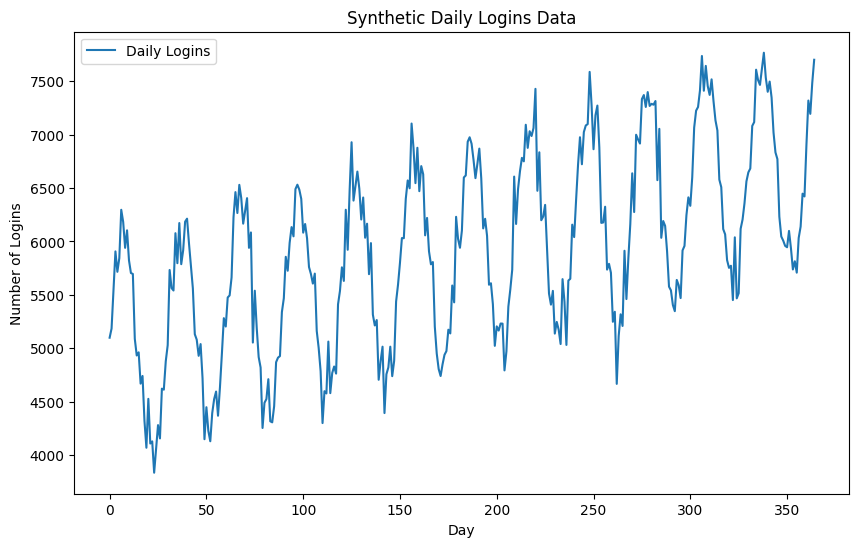

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
time = np.arange(365)  # 365 days
seasonality = 1000 * np.sin(2 * np.pi * time / 30)  # Monthly seasonality
trend = 5 * time  # Linear trend
noise = np.random.normal(0, 200, 365)  # Random noise
daily_logins = 5000 + trend + seasonality + noise  # Base logins + components

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, daily_logins, label='Daily Logins')
plt.title('Synthetic Daily Logins Data')
plt.xlabel('Day')
plt.ylabel('Number of Logins')
plt.legend()
plt.show()

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
daily_logins_scaled = scaler.fit_transform(daily_logins.reshape(-1, 1))

# Create sequences (e.g., use past 10 days to predict the next day)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(daily_logins_scaled, seq_length)

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (284, 10, 1), Test data shape: (71, 10, 1)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Define the Liquid Neural Network class
class LiquidNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Input to hidden layer
        self.W_in = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        # Recurrent weights (liquid-like dynamics)
        self.W_rec = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        # Hidden to output
        self.W_out = nn.Linear(hidden_size, output_size)
        
        # Time constant (learnable)
        self.tau = nn.Parameter(torch.ones(hidden_size) * 10.0)  # Initial time constant

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        h = torch.zeros(batch_size, self.hidden_size)  # Initial hidden state
        
        # Simulate liquid dynamics over time steps
        for t in range(seq_len):
            # Input contribution
            input_term = torch.matmul(x[:, t, :], self.W_in)
            # Recurrent contribution
            recurrent_term = torch.matmul(h, self.W_rec)
            # Differential equation-like update (simplified)
            dh = (-h + input_term + recurrent_term) / self.tau
            h = h + dh  # Euler integration step
        
        # Output
        out = self.W_out(h)
        return out

# Model parameters
input_size = 1  # Single feature (daily logins)
hidden_size = 20  # Number of hidden neurons
output_size = 1  # Predict one value

# Initialize model, loss, and optimizer
model = LiquidNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0732
Epoch [20/100], Loss: 0.0402
Epoch [30/100], Loss: 0.0355
Epoch [40/100], Loss: 0.0296
Epoch [50/100], Loss: 0.0262
Epoch [60/100], Loss: 0.0235
Epoch [70/100], Loss: 0.0207
Epoch [80/100], Loss: 0.0171
Epoch [90/100], Loss: 0.0130
Epoch [100/100], Loss: 0.0091


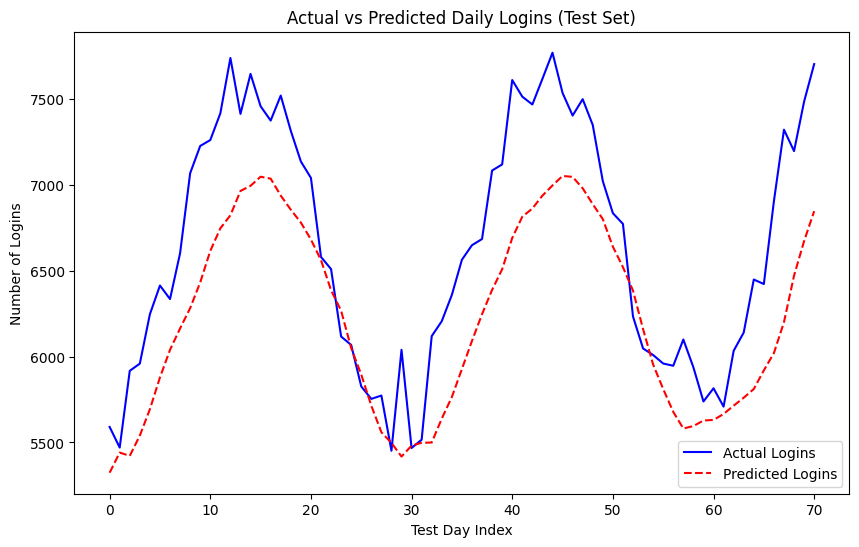

Mean Squared Error on Test Set: 260238.59


In [4]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Inverse transform to original scale
y_test_orig = scaler.inverse_transform(y_test.numpy())
y_pred_orig = scaler.inverse_transform(y_pred.numpy())

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_orig)), y_test_orig, label='Actual Logins', color='blue')
plt.plot(range(len(y_pred_orig)), y_pred_orig, label='Predicted Logins', color='red', linestyle='--')
plt.title('Actual vs Predicted Daily Logins (Test Set)')
plt.xlabel('Test Day Index')
plt.ylabel('Number of Logins')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = np.mean((y_test_orig - y_pred_orig) ** 2)
print(f"Mean Squared Error on Test Set: {mse:.2f}")